In [1]:
import pandas as pd
import numpy as np

df_metro = pd.read_csv("../data/Cleaned4weekRealestateData.csv")

In [2]:
df_metro.head()

,PERIOD_BEGIN,PERIOD_END,REGION_TYPE,REGION_TYPE_ID,REGION_NAME,REGION_ID,ADJUSTED_AVERAGE_NEW_LISTINGS,ADJUSTED_AVERAGE_NEW_LISTINGS_YOY,AVERAGE_PENDING_SALES_LISTING_UPDATES,AVERAGE_PENDING_SALES_LISTING_UPDATES_YOY,...,AGE_OF_INVENTORY_YOY,WEEKS_OF_SUPPLY,WEEKS_OF_SUPPLY_YOY,MEDIAN_PENDING_SQFT,MEDIAN_PENDING_SQFT_YOY,AVERAGE_SALE_TO_LIST_RATIO,AVERAGE_SALE_TO_LIST_RATIO_YOY,MEDIAN_SALE_PPSF,MEDIAN_SALE_PPSF_YOY,LAST_UPDATED
0,2017-01-02,2017-01-29,metro,-2,"Aberdeen, SD metro area",10100,4.50,-0.419355,5.50,0.100000,...,-10.750,21.701389,-1.841468,2317.000,0.129624,0.991026,0.040947,82.612505,0.000237,2025-09-24 13:36:20.730
1,2017-01-09,2017-02-05,metro,-2,"Aberdeen, SD metro area",10100,3.25,-0.535714,6.25,0.250000,...,-3.875,17.034722,-7.174802,2400.625,0.160984,0.977997,0.035702,81.958745,0.072890,2025-09-24 13:36:20.730
2,2017-01-16,2017-02-12,metro,-2,"Aberdeen, SD metro area",10100,4.25,-0.370370,4.25,-0.055556,...,4.250,26.020833,-0.045833,2420.125,0.195271,0.978080,0.024140,80.368410,0.087961,2025-09-24 13:36:20.730
3,2017-01-23,2017-02-19,metro,-2,"Aberdeen, SD metro area",10100,5.50,-0.266667,3.75,-0.062500,...,7.500,32.708333,2.191667,2285.500,0.167784,0.964273,-0.007444,76.648096,-0.120064,2025-09-24 13:36:20.730
4,2017-01-30,2017-02-26,metro,-2,"Aberdeen, SD metro area",10100,7.25,0.115385,3.25,-0.187500,...,5.375,35.541667,4.575000,2459.000,0.354914,0.963298,0.022579,76.525164,-0.026367,2025-09-24 13:36:20.730


In [3]:
trend_summary = (
    df_metro.groupby("PERIOD_BEGIN")[["MEDIAN_SALE_PRICE",
                                      "ACTIVE_LISTINGS",
                                      "MEDIAN_DAYS_TO_CLOSE",
                                      "PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS"]]
    .mean()
    .reset_index()
)

print(trend_summary.head())

  PERIOD_BEGIN  MEDIAN_SALE_PRICE  ACTIVE_LISTINGS  MEDIAN_DAYS_TO_CLOSE  \
0   2017-01-02      167210.194986      2528.341991             10.329320   
1   2017-01-09      166319.075009      2546.212743             10.166217   
2   2017-01-16      165173.415902      2564.667387             10.053951   
3   2017-01-23      165419.971337      2587.659827              9.054491   
4   2017-01-30      165972.948739      2613.224865              8.593964   

   PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS  
0                                  0.023585  
1                                  0.024931  
2                                  0.024873  
3                                  0.024915  
4                                  0.024715  


In [8]:
trend_summary["PERIOD_BEGIN"] = pd.to_datetime(trend_summary["PERIOD_BEGIN"], errors="coerce")


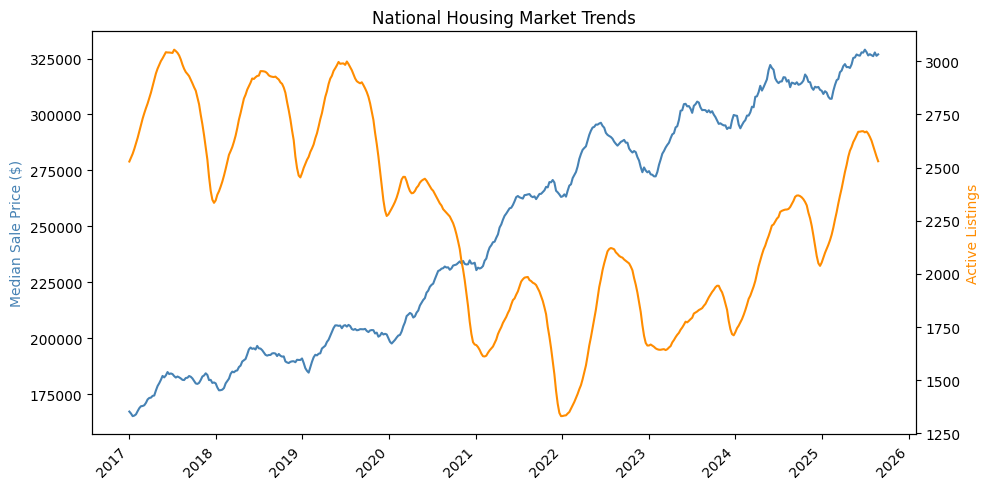

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(trend_summary["PERIOD_BEGIN"], trend_summary["MEDIAN_SALE_PRICE"], label="Median Sale Price", color="steelblue")
ax1.set_ylabel("Median Sale Price ($)", color="steelblue")

ax2 = ax1.twinx()
ax2.plot(trend_summary["PERIOD_BEGIN"], trend_summary["ACTIVE_LISTINGS"], label="Active Listings", color="darkorange")
ax2.set_ylabel("Active Listings", color="darkorange")

# --- Format x-axis ---
ax1.xaxis.set_major_locator(mdates.YearLocator())        # show one tick per year
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # format as YYYY
fig.autofmt_xdate(rotation=45)                           # rotate labels for readability

plt.title("National Housing Market Trends")
fig.tight_layout()
plt.show()


In [11]:
# Percent change (momentum) and supply dynamics
trend_summary["Price_Momentum"] = trend_summary["MEDIAN_SALE_PRICE"].pct_change()
trend_summary["Supply_Pressure"] = trend_summary["ACTIVE_LISTINGS"].pct_change()

# 8-week smoothing to reduce noise
trend_summary["Price_Momentum_Smoothed"] = trend_summary["Price_Momentum"].rolling(8).mean()
trend_summary["Supply_Pressure_Smoothed"] = trend_summary["Supply_Pressure"].rolling(8).mean()


In [12]:
trend_summary["Entry_Signal"] = (
    (trend_summary["Price_Momentum_Smoothed"] < 0)
    & (trend_summary["Supply_Pressure_Smoothed"] > 0)
)
trend_summary["Exit_Signal"] = (
    (trend_summary["Price_Momentum_Smoothed"] > 0)
    & (trend_summary["Supply_Pressure_Smoothed"] < 0)
)


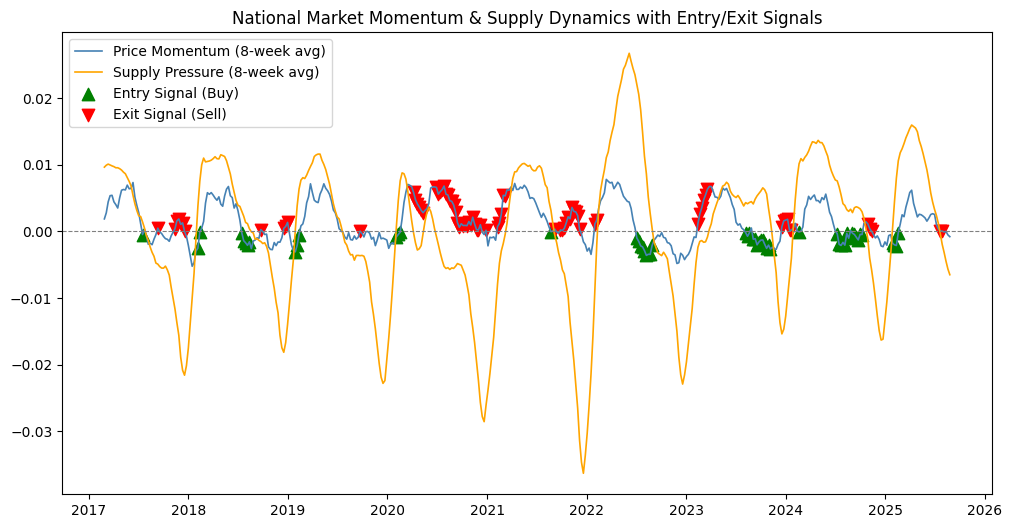

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(trend_summary["PERIOD_BEGIN"], trend_summary["Price_Momentum_Smoothed"],
         label="Price Momentum (8-week avg)", color="steelblue", linewidth=1.2)
plt.plot(trend_summary["PERIOD_BEGIN"], trend_summary["Supply_Pressure_Smoothed"],
         label="Supply Pressure (8-week avg)", color="orange", linewidth=1.2)

# Entry (Buy) signals
plt.scatter(
    trend_summary.loc[trend_summary["Entry_Signal"], "PERIOD_BEGIN"],
    trend_summary.loc[trend_summary["Entry_Signal"], "Price_Momentum_Smoothed"],
    color="green", marker="^", s=80, label="Entry Signal (Buy)"
)

# Exit (Sell) signals
plt.scatter(
    trend_summary.loc[trend_summary["Exit_Signal"], "PERIOD_BEGIN"],
    trend_summary.loc[trend_summary["Exit_Signal"], "Price_Momentum_Smoothed"],
    color="red", marker="v", s=80, label="Exit Signal (Sell)"
)

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("National Market Momentum & Supply Dynamics with Entry/Exit Signals")
plt.legend()
plt.show()


In [13]:
signals = trend_summary.loc[
    trend_summary["Entry_Signal"] | trend_summary["Exit_Signal"],
    ["PERIOD_BEGIN", "Price_Momentum_Smoothed", "Supply_Pressure_Smoothed", "Entry_Signal", "Exit_Signal"]
].copy()

signals["Signal_Type"] = signals.apply(
    lambda x: "BUY (Entry)" if x["Entry_Signal"] else "SELL (Exit)", axis=1
)

print(signals.head(10))

   PERIOD_BEGIN  Price_Momentum_Smoothed  Supply_Pressure_Smoothed  \
28   2017-07-17                -0.000478                  0.001416   
36   2017-09-11                 0.000473                 -0.004920   
45   2017-11-13                 0.000408                 -0.011660   
46   2017-11-20                 0.001576                 -0.013710   
47   2017-11-27                 0.001854                 -0.015587   
48   2017-12-04                 0.001051                 -0.018905   
49   2017-12-11                 0.001272                 -0.020855   
50   2017-12-18                 0.000002                 -0.021596   
57   2018-02-05                -0.002519                  0.003746   
58   2018-02-12                -0.000124                  0.007497   

    Entry_Signal  Exit_Signal  Signal_Type  
28          True        False  BUY (Entry)  
36         False         True  SELL (Exit)  
45         False         True  SELL (Exit)  
46         False         True  SELL (Exit)  
47  

In [14]:
import numpy as np

# Find indices of entry and exit signals
entries = trend_summary.index[trend_summary["Entry_Signal"]]
exits = trend_summary.index[trend_summary["Exit_Signal"]]

cycle_lengths = []
for e in entries:
    later_exits = exits[exits > e]
    if len(later_exits) > 0:
        cycle_lengths.append(later_exits[0] - e)

print(f"Average market cycle length: {np.mean(cycle_lengths):.1f} weeks")


Average market cycle length: 16.4 weeks
